**Import libraies..................**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf                                                 
import sklearn.model_selection     
import keras.preprocessing.image  
import datetime                    
import skimage.transform           
import skimage.morphology          
import cv2                        
import os                        
import random  
import sys                         
import tqdm           
import warnings          
import seaborn as sns              
import matplotlib.pyplot as plt   
import matplotlib.cm as cm        

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import skimage.io
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from textwrap import wrap

In [ ]:
from os.path import join
import glob
from tqdm import tqdm
import itertools
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Conv2D, UpSampling2D, Lambda
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
# Remember to enable GPU
%matplotlib inline

**Mount drive to notebook for accessing the input data............**



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/My Drive/nuclei"

accuracy_curve.png	      stage1_solution.csv
logs.npy		      stage1_test
loss_curve.png		      stage1_train
model-dsbowl2018-1.h5	      stage1_train_labels.csv
model-dsbowl2018-2.h5	      stage2_sample_submission_final.csv
model-dsbowl2018-3.h5	      stage2_test_final
stage1_sample_submission.csv  sub-dsbowl2018-1.csv


# EDA.............

In [ ]:
#IMG_WIDTH = 256       
#IMG_HEIGHT = 256
IMG_WIDTH = 128      
IMG_HEIGHT = 128      
IMG_CHANNELS = 3      
CW_DIR = os.getcwd()  
print(CW_DIR)
TRAIN_DIR = os.path.join(os.path.dirname(CW_DIR), '/content/gdrive/My Drive/nuclei', 'stage1_train')
TEST_DIR = os.path.join(os.path.dirname(CW_DIR), '/content/gdrive/My Drive/nuclei', 'stage1_test')
IMG_TYPE = '.png'        
IMG_DIR_NAME = 'images'   
MASK_DIR_NAME = 'masks'   
LOGS_DIR_NAME = 'logs'    
SAVES_DIR_NAME = 'saves'  
SEED = 123               

/content


In [ ]:
min_object_size = 1      
x_train = []
y_train = []
x_test = []
y_test_pred_proba = {}
y_test_pred = {}
print('CW_DIR = {}'.format(CW_DIR))
print('TRAIN_DIR = {}'.format(TRAIN_DIR))
print('TEST_DIR = {}'.format(TEST_DIR))

CW_DIR = /content
TRAIN_DIR = /content/gdrive/My Drive/nuclei/stage1_train
TEST_DIR = /content/gdrive/My Drive/nuclei/stage1_test


In [ ]:
def read_image(filepath, color_mode=cv2.IMREAD_COLOR, target_size=None):
    """Read an image from a file and resize it."""
    img = cv2.imread(filepath, color_mode)
    if target_size: 
        img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)
    return img

In [ ]:
def read_mask(directory, target_size=None):
    """Read and resize masks contained in a given directory."""
    for i,filename in enumerate(next(os.walk(directory))[2]):
        mask_path = os.path.join(directory, filename)
        mask_tmp = read_image(mask_path, cv2.IMREAD_GRAYSCALE, target_size)
        if not i: mask = mask_tmp
        else: mask = np.maximum(mask, mask_tmp)
    return mask

In [ ]:
def read_train_data_properties(train_dir, img_dir_name, mask_dir_name):
    """Read basic properties of training images and masks"""
    tmp = []
    for i,dir_name in enumerate(next(os.walk(train_dir))[1]):

        img_dir = os.path.join(train_dir, dir_name, img_dir_name)
        #print(img_dir)
        mask_dir = os.path.join(train_dir, dir_name, mask_dir_name) 
        #print(mask_dir)
        num_masks = len(next(os.walk(mask_dir))[2])
        #print(num_masks)
        try:
          img_name = next(os.walk(img_dir))[2][0]
          #print(img_name)
          img_name_id = os.path.splitext(img_name)[0]
          #print(img_name_id)
          img_path = os.path.join(img_dir, img_name)
          #print(img_path)
          img_shape = read_image(img_path).shape
          tmp.append(['{}'.format(img_name_id), img_shape[0], img_shape[1],
                    img_shape[0]/img_shape[1], img_shape[2], num_masks,
                    img_path, mask_dir])
        except StopIteration:
          pass
    train_df = pd.DataFrame(tmp, columns = ['img_id', 'img_height', 'img_width',
                                            'img_ratio', 'num_channels', 
                                            'num_masks', 'image_path', 'mask_dir'])
    return train_df

In [ ]:
def read_test_data_properties(test_dir, img_dir_name):
    """Read basic properties of test images."""
    tmp = []
    for i,dir_name in enumerate(next(os.walk(test_dir))[1]):

        img_dir = os.path.join(test_dir, dir_name, img_dir_name)
        img_name = next(os.walk(img_dir))[2][0]
        img_name_id = os.path.splitext(img_name)[0]
        img_path = os.path.join(img_dir, img_name)
        img_shape = read_image(img_path).shape
        tmp.append(['{}'.format(img_name_id), img_shape[0], img_shape[1],
                    img_shape[0]/img_shape[1], img_shape[2], img_path])

    test_df = pd.DataFrame(tmp, columns = ['img_id', 'img_height', 'img_width',
                                           'img_ratio', 'num_channels', 'image_path'])
    return test_df

In [ ]:
def imshow_args(x):
    """Matplotlib imshow arguments for plotting."""
    if len(x.shape)==2: return x, cm.gray
    if x.shape[2]==1: return x[:,:,0], cm.gray
    return x, None

In [ ]:
train_ids = next(os.walk(TRAIN_DIR))[1]
test_ids = next(os.walk(TEST_DIR))[1]

def load_raw_data(image_size=(IMG_HEIGHT, IMG_WIDTH)):
  X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  print('Getting and resizing train images and masks ... ')
  sys.stdout.flush()
  for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
      path = TRAIN_PATH + id_
      img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
      img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      X_train[n] = img
      mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
      for mask_file in next(os.walk(path + '/masks/'))[2]:
          mask_ = imread(path + '/masks/' + mask_file)
          mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
          mask = np.maximum(mask, mask_)
      Y_train[n] = mask

  # Get and resize test images
  X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
  sizes_test = []
  print('Getting and resizing test images ... ')
  sys.stdout.flush()
  for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
      path = TEST_PATH + id_
      img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
      sizes_test.append([img.shape[0], img.shape[1]])
      img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      X_test[n] = img
  return X_train, Y_train, X_test
  print('Done!')

In [ ]:
"""
def load_raw_data(image_size=(IMG_HEIGHT, IMG_WIDTH)):
    """Load raw data."""
    # Python lists to store the training images/masks and test images.
    x_train, y_train, x_test = [],[],[]

    # Read and resize train images/masks. 
    print('Loading and resizing train images and masks ...')
    sys.stdout.flush()
    for i, filename in tqdm.tqdm(enumerate(train_df['image_path']), total=len(train_df)):
        img = read_image(train_df['image_path'].loc[i], target_size=image_size)
        mask = read_mask(train_df['mask_dir'].loc[i], target_size=image_size)
        x_train.append(img)
        y_train.append(mask)

    # Read and resize test images. 
    print('Loading and resizing test images ...')
    sys.stdout.flush()
    for i, filename in tqdm.tqdm(enumerate(test_df['image_path']), total=len(test_df)):
        img = read_image(test_df['image_path'].loc[i], target_size=image_size)
        x_test.append(img)

    # Transform lists into 4-dim numpy arrays.
    x_train = np.array(x_train)
    y_train = np.expand_dims(np.array(y_train), axis=4)
    x_test = np.array(x_test)

    print('x_train.shape: {} of dtype {}'.format(x_train.shape, x_train.dtype))
    print('y_train.shape: {} of dtype {}'.format(y_train.shape, x_train.dtype))
    print('x_test.shape: {} of dtype {}'.format(x_test.shape, x_test.dtype))
    
    return x_train, y_train, x_test
"""

*Basic properties of images/masks.............*

In [ ]:
train_df = read_train_data_properties(TRAIN_DIR, IMG_DIR_NAME, MASK_DIR_NAME)
test_df = read_test_data_properties(TEST_DIR, IMG_DIR_NAME)
print('train_df:')
print(train_df.describe())
print('')
print('test_df:')
print(test_df.describe())

train_df:
        img_height    img_width   img_ratio  num_channels   num_masks
count   670.000000   670.000000  670.000000         670.0  670.000000
mean    333.991045   378.500000    0.921008           3.0   43.971642
std     149.474845   204.838693    0.114294           0.0   47.962530
min     256.000000   256.000000    0.474057           3.0    1.000000
25%     256.000000   256.000000    0.800000           3.0   15.250000
50%     256.000000   320.000000    1.000000           3.0   27.000000
75%     360.000000   360.000000    1.000000           3.0   54.000000
max    1040.000000  1388.000000    1.000000           3.0  375.000000

test_df:
       img_height   img_width  img_ratio  num_channels
count   65.000000   65.000000  65.000000          65.0
mean   402.676923  393.184615   1.186171           3.0
std    129.082956  189.813386   0.631035           0.0
min    256.000000  161.000000   0.747126           3.0
25%    256.000000  256.000000   0.800000           3.0
50%    512.000000  2

*Counting unique image shapes.................*


In [ ]:
df = pd.DataFrame([[x] for x in zip(train_df['img_height'], train_df['img_width'])])
df[0].value_counts()

(256, 256)      334
(256, 320)      112
(520, 696)       92
(360, 360)       91
(1024, 1024)     16
(512, 640)       13
(603, 1272)       6
(260, 347)        5
(1040, 1388)      1
Name: 0, dtype: int64

*Overview of train images/masks. There is a lot of variation concerning the form/ size/ number of nuclei and the darkness/ lightness/ colorfulness of the images................*

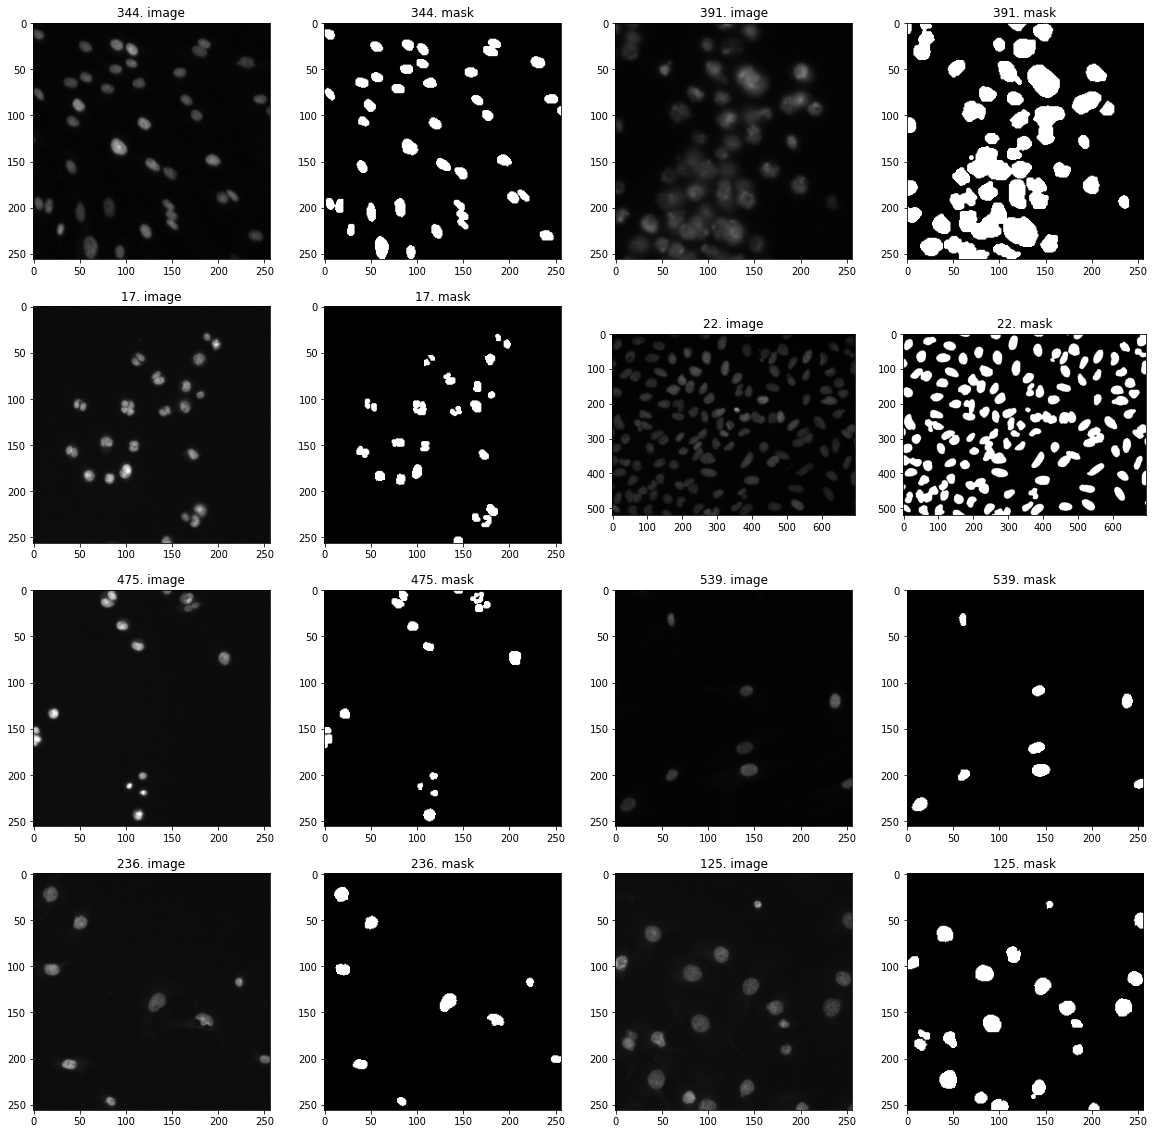

In [ ]:
fig, axs = plt.subplots(4,4,figsize=(20,20))
for i in range(4):
    for j in range(2):
        n = np.random.randint(0,len(train_df))
        axs[i,j*2].imshow(read_image(train_df['image_path'].loc[n]))
        axs[i,j*2].set_title('{}. image'.format(n))
        axs[i,j*2+1].imshow(read_mask(train_df['mask_dir'].loc[n]), cmap='gray') 
        axs[i,j*2+1].set_title('{}. mask'.format(n))      

*Read images/masks from files and resize them. Each image and mask is stored as a 3-dim array where the number of channels is 3 and 1, respectively....*


In [ ]:
from tqdm import tqdm
x_train, y_train, x_test = load_raw_data()

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [09:06<00:00,  1.23it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:02<00:00, 24.52it/s]


*Study the pixel intensity. On average the red, green and blue channels have similar intensities for all images. It should be noted that the background can be dark (black) as  as well as light (white)......*

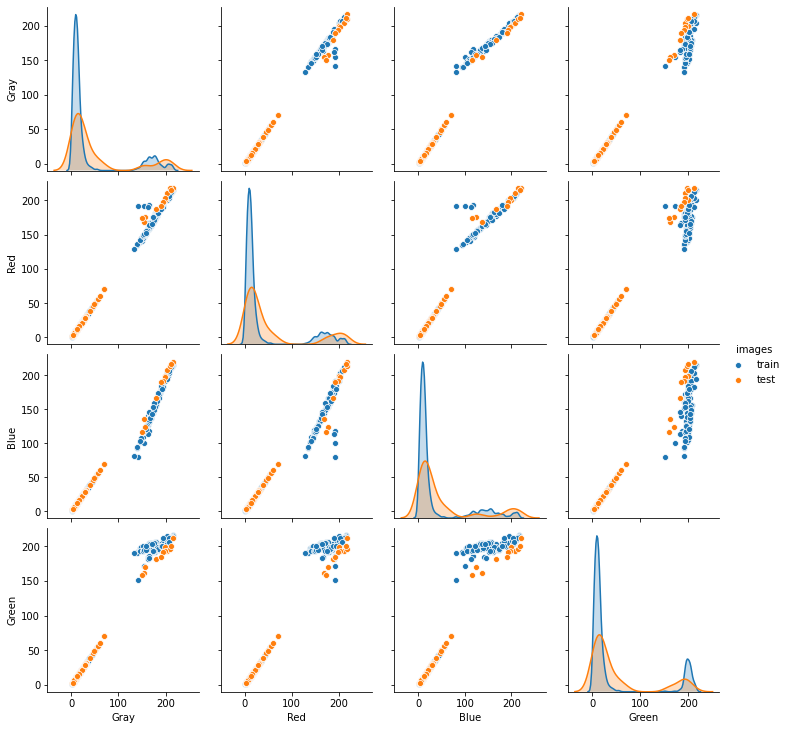

In [ ]:
def img_intensity_pairplot(x):
    """Plot intensity distributions of color channels."""
    df = pd.DataFrame()
    df['Gray'] = np.mean(x[:,:,:,:], axis=(1,2,3))
    if x.shape[3]==3:
        df['Red'] = np.mean(x[:,:,:,0], axis=(1,2))
        df['Blue'] = np.mean(x[:,:,:,1], axis=(1,2))
        df['Green'] = np.mean(x[:,:,:,2], axis=(1,2))
    return df

color_df = img_intensity_pairplot(np.concatenate([x_train, x_test]))
color_df['images'] = ['train']*len(x_train) + ['test']*len(x_test)
sns.pairplot(color_df, hue = 'images')



# Data Transfomrattion for EDA................



Collection of methods for basic data manipulation like normalizing, inverting, color transformation and generating new images/masks

In [ ]:
def normalize_imgs(data):
    """Normalize images."""
    return normalize(data, type_=1)

def normalize_masks(data):
    """Normalize masks."""
    return normalize(data, type_=1)

In [ ]:
def normalize(data, type_=1): 
    """Normalize data."""
    if type_==0:
        # Convert pixel values from [0:255] to [0:1] by global factor
        data = data.astype(np.float32) / data.max()
    if type_==1:
        # Convert pixel values from [0:255] to [0:1] by local factor
        div = data.max(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        div[div < 0.01*data.mean()] = 1. # protect against too small pixel intensities
        data = data.astype(np.float32)/div
    if type_==2:
        # Standardisation of each image 
        data = data.astype(np.float32) / data.max() 
        mean = data.mean(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        std = data.std(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        data = (data-mean)/std

    return data

In [ ]:
def trsf_proba_to_binary(y_data):
    """Transform propabilities into binary values 0 or 1."""  
    return np.greater(y_data,.5).astype(np.uint8)

def invert_imgs(imgs, cutoff=.5):
    '''Invert image if mean value is greater than cutoff.'''
    imgs = np.array(list(map(lambda x: 1.-x if np.mean(x)>cutoff else x, imgs)))
    return normalize_imgs(imgs)

In [ ]:
def imgs_to_grayscale(imgs):
    '''Transform RGB images into grayscale spectrum.''' 
    if imgs.shape[3]==3:
        imgs = normalize_imgs(np.expand_dims(np.mean(imgs, axis=3), axis=3))
    return imgs

In [ ]:
def generate_images(imgs, seed=None):
    """Generate new images."""
    # Transformations.
    image_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 90., width_shift_range = 0.02 , height_shift_range = 0.02,
        zoom_range = 0.10, horizontal_flip=True, vertical_flip=True)
    
    # Generate new set of images
    image_generator.fit(imgs)
    imgs = image_generator.flow(imgs, np.zeros(len(imgs)), batch_size=1,
                                shuffle = False, seed=seed).next() 
    return imgs[0]


In [ ]:
def generate_images_and_masks(imgs, masks):
    """Generate new images and masks."""
    seed = np.random.randint(10000) 
    masks = trsf_proba_to_binary(generate_images(masks, seed=seed))
    imgs = generate_images(imgs, seed=seed)
    return imgs, masks

In [ ]:
def preprocess_raw_data(x_train, y_train, x_test, grayscale=False, invert=False):
    """Preprocessing of images and masks."""
    # Normalize images and masks
    x_train = normalize_imgs(x_train)
    y_train = trsf_proba_to_binary(normalize_masks(y_train))
    x_test = normalize_imgs(x_test)
    print('Images normalized.')
 
    if grayscale:
        # Remove color and transform images into grayscale spectrum.
        x_train = imgs_to_grayscale(x_train)
        x_test = imgs_to_grayscale(x_test)
        print('Images transformed into grayscale spectrum.')

    if invert:
        # Invert images, such that each image has a dark background.
        x_train = invert_imgs(x_train)
        x_test = invert_imgs(x_test)
        print('Images inverted to remove light backgrounds.')

    return x_train, y_train, x_test

*Normalize all images and masks. There is the possibility to transform images  into the grayscale sepctrum and to invert images which have a very  light background..............*

In [ ]:
x_train, y_train, x_test = preprocess_raw_data(x_train, y_train, x_test, invert=True)

Images normalized.
Images inverted to remove light backgrounds.


*Analyze nuclei sizes.....*


In [ ]:
def get_nuclei_sizes():
    nuclei_sizes = []
    mask_idx = []
    for i in range(len(y_train)):
        mask = y_train[i].reshape(y_train.shape[1], y_train.shape[2])
        lab_mask = skimage.morphology.label(mask > .5)
        (mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
        nuclei_sizes.extend(mask_sizes[1:])
        mask_idx.extend([i]*len(mask_sizes[1:]))
    return mask_idx, nuclei_sizes

mask_idx, nuclei_sizes = get_nuclei_sizes()
nuclei_sizes_df = pd.DataFrame()   
nuclei_sizes_df['mask_index'] = mask_idx
nuclei_sizes_df['nucleous_size'] = nuclei_sizes

print(nuclei_sizes_df.describe())
nuclei_sizes_df.sort_values(by='nucleous_size', ascending=True).head(10)

         mask_index  nucleous_size
count  15206.000000   15206.000000
mean     337.232408     144.738130
std      190.253927     289.798439
min        0.000000       2.000000
25%      185.000000      45.000000
50%      329.000000      71.000000
75%      510.000000     138.000000
max      669.000000    8625.000000


,mask_index,nucleous_size
2258,111,2
9997,440,4
6559,286,4
5330,240,4
13893,612,5
12159,538,5
1385,69,5
8258,363,5
2600,128,5
1382,69,6


*Image intensity pairplot............................*

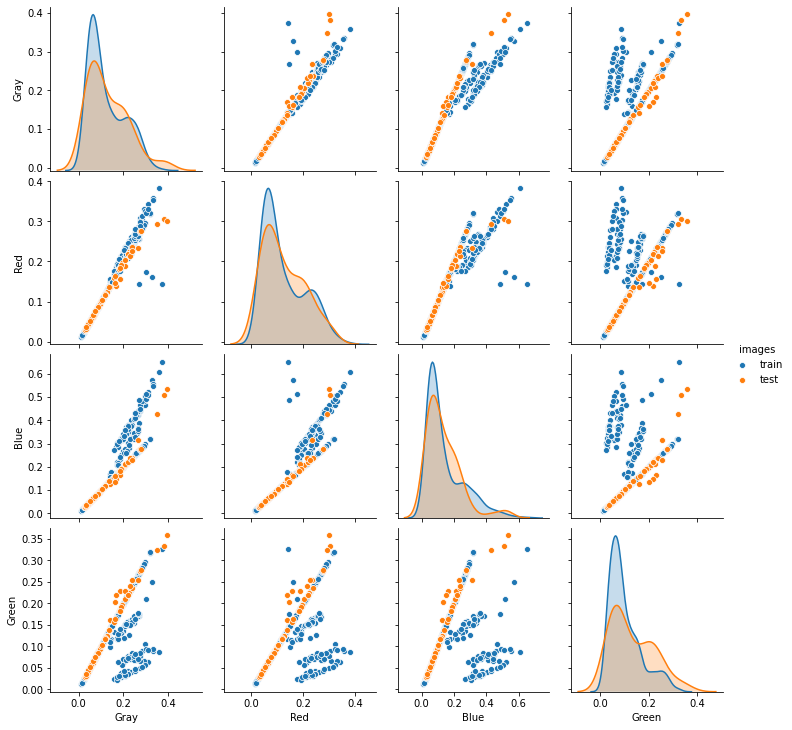

In [ ]:
color_df = img_intensity_pairplot(np.concatenate([x_train, x_test]))
color_df['images'] = ['train']*len(x_train) + ['test']*len(x_test)
sns.pairplot(color_df, hue = 'images');

*Check the image transformation procedure (resizing, normalizing, inverting) by looking at a sample..........*

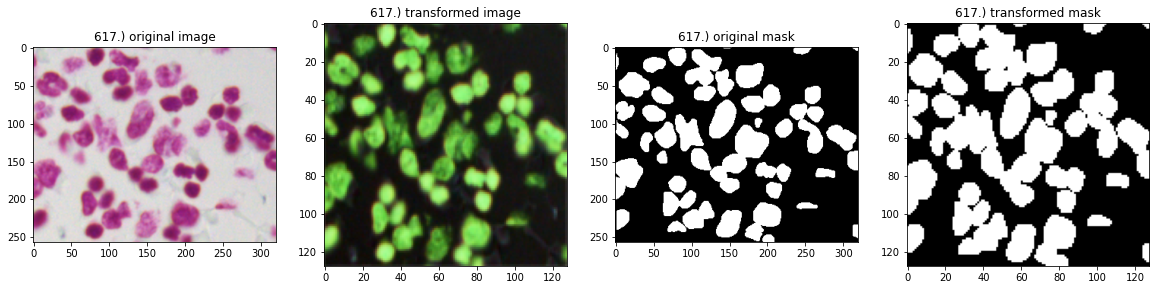

In [ ]:
def img_comparison_plot(n):
    """Plot the original and transformed images/masks."""
    fig, axs = plt.subplots(1,4,figsize=(20,20))
    axs[0].imshow(read_image(train_df['image_path'].loc[n]))
    axs[0].set_title('{}.) original image'.format(n))
    img, img_type = imshow_args(x_train[n])
    axs[1].imshow(img, img_type)
    axs[1].set_title('{}.) transformed image'.format(n))
    axs[2].imshow(read_mask(train_df['mask_dir'].loc[n]), cm.gray) 
    axs[2].set_title('{}.) original mask'.format(n))
    axs[3].imshow(y_train[n,:,:,0], cm.gray)
    axs[3].set_title('{}.) transformed mask'.format(n));

n = 617 # np.random.randint(0, len(x_train))
img_comparison_plot(n)

*Generate new images/masks via transformations applied on the original images/maks. Data augmentations can be used for regularization......*

In [ ]:
def plot_generated_image_mask(n):
    fig, axs = plt.subplots(1,4,figsize=(20,20))
    img_new, mask_new = generate_images_and_masks(x_train[n:n+1], y_train[n:n+1])
    img, img_type = imshow_args(x_train[n])
    axs[0].imshow(img, img_type)
    axs[0].set_title('{}. original image'.format(n))
    img, img_type = imshow_args(img_new[0])
    axs[1].imshow(img, img_type)
    axs[1].set_title('{}. generated image'.format(n))
    axs[2].imshow(y_train[n,:,:,0], cmap='gray')
    axs[2].set_title('{}. original mask'.format(n))
    axs[3].imshow(mask_new[0,:,:,0], cmap='gray')
    axs[3].set_title('{}. generated mask'.format(n))

#n = np.random.randint(len(x_train))
n = 100
#plot_generated_image_mask(n)

In [ ]:
STAGE1_TRAIN = "/content/gdrive/My Drive/nuclei/stage1_train"
STAGE1_TRAIN_IMAGE_PATTERN = "%s/{}/images/{}.png" % STAGE1_TRAIN
STAGE1_TRAIN_MASK_PATTERN = "%s/{}/masks/*.png" % STAGE1_TRAIN
IMAGE_ID = "image_id"
IMAGE_WIDTH = "width"
IMAGE_WEIGHT = "height"
HSV_CLUSTER = "hsv_cluster"
HSV_DOMINANT = "hsv_dominant"
TOTAL_MASK = "total_masks"

In [ ]:
def image_ids_in(root_dir, ignore=[]):
    ids = []
    for id in os.listdir(root_dir):
        if id in ignore:
            print('Skipping ID:', id)
        else:
            ids.append(id)
    return ids

In [ ]:
def read_image(image_id, space="rgb"):
    image_file = STAGE1_TRAIN_IMAGE_PATTERN.format(image_id, image_id)
    image = skimage.io.imread(image_file)
    # Drop alpha which is not used
    image = image[:, :, :3]
    if space == "hsv":
        image = skimage.color.rgb2hsv(image)
    return image

*Get image width, height and count masks available.....*


In [ ]:
def read_image_labels(image_id, space="rgb"):
    image = read_image(image_id, space = space)
    mask_file = STAGE1_TRAIN_MASK_PATTERN.format(image_id)
    masks = skimage.io.imread_collection(mask_file).concatenate()    
    height, width, _ = image.shape
    num_masks = masks.shape[0]
    labels = np.zeros((height, width), np.uint16)
    for index in range(0, num_masks):
        labels[masks[index] > 0] = 255 #index + 1
    return image, labels, num_masks

*Load stage 1 image identifiers........*


In [ ]:
train_image_ids = image_ids_in(STAGE1_TRAIN)

In [ ]:
def get_domimant_colors(img, top_colors=2):
    img_l = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    clt = KMeans(n_clusters = top_colors)
    clt.fit(img_l)
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    return clt.cluster_centers_, hist

In [ ]:
def get_images_details(image_ids):
    details = []
    i = 0
    for image_id in image_ids:
        print(i)
        image_hsv, labels, num_masks = read_image_labels(image_id, space="hsv")
        height, width, l = image_hsv.shape
        dominant_colors_hsv, dominant_rates_hsv = get_domimant_colors(image_hsv, top_colors=1)
        dominant_colors_hsv = dominant_colors_hsv.reshape(1, dominant_colors_hsv.shape[0] * dominant_colors_hsv.shape[1])
        info = (image_id, width, height, num_masks, dominant_colors_hsv.squeeze())
        details.append(info)
        i += 1
    return details

In [ ]:
META_COLS = [IMAGE_ID, IMAGE_WIDTH, IMAGE_WEIGHT, TOTAL_MASK]
COLS = META_COLS + [HSV_DOMINANT]

In [ ]:
details = get_images_details(train_image_ids)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KMeans to split images by 3 types (based on dominant HSV colors distributions)

In [ ]:
trainPD = pd.DataFrame(details, columns=COLS)
X = pd.DataFrame(trainPD[HSV_DOMINANT].values.tolist())
X = X.values
kmeans = KMeans(n_clusters=3).fit(X)
clusters = kmeans.predict(X)
trainPD[HSV_CLUSTER] = clusters

In [ ]:
trainPD.head()

,image_id,width,height,total_masks,hsv_dominant,hsv_cluster
0,3bfd6bb152310f93daa6f4e1867c10572946e874b3a30c...,256,256,32,"[0.0, 0.0, 0.035346236883422866]",0
1,e66a97b2c77f3d66a7d3cebbc6a36c8c6259368a397f7b...,256,256,11,"[0.0, 0.0, 0.06803241804534348]",0
2,feffce59a1a3eb0a6a05992bb7423c39c7d52865846da3...,256,256,38,"[0.0, 0.0, 0.07628712373621666]",0
3,f26f4c2c70c38fe12e00d5a814d5116691f2ca54890812...,256,256,52,"[0.0, 0.0, 0.05301022997089236]",0
4,e23e11414ee645b51081fb202d38b793f0c8ef2940f822...,696,520,199,"[0.0, 0.0, 0.09731008694370719]",0


In [ ]:
def plot_images(images, images_rows, images_cols):
    f, axarr = plt.subplots(images_rows,images_cols,figsize=(16,images_rows*2))
    for row in range(images_rows):
        for col in range(images_cols):
            image_id = images[row*images_cols + col]
            image = read_image(image_id)
            height, width, l = image.shape
            ax = axarr[row,col]
            ax.axis('off')
            ax.set_title("%dx%d"%(width, height))
            ax.imshow(image)

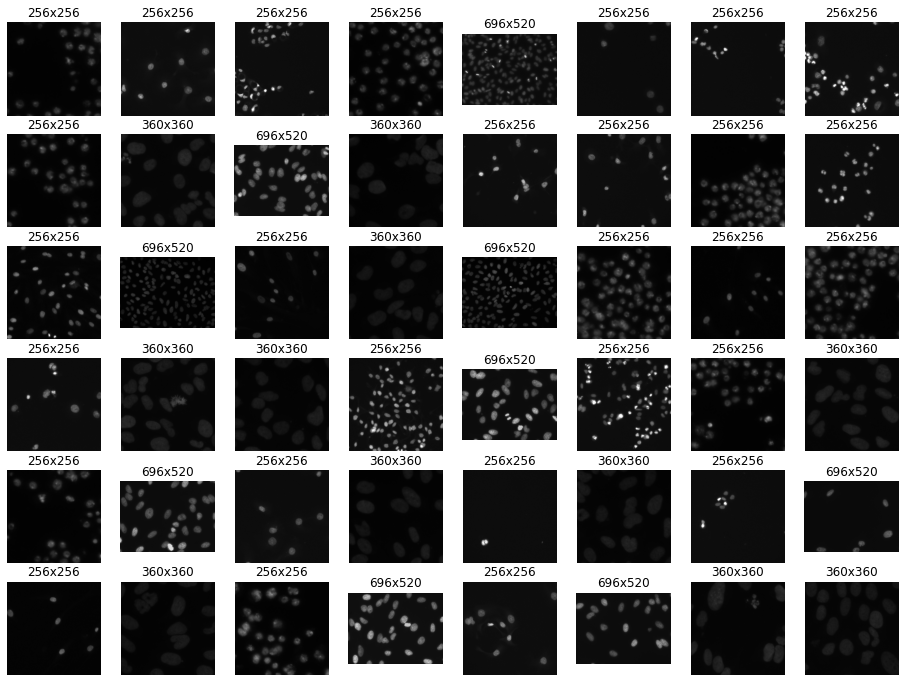

In [ ]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 0][IMAGE_ID].values, 6, 8)

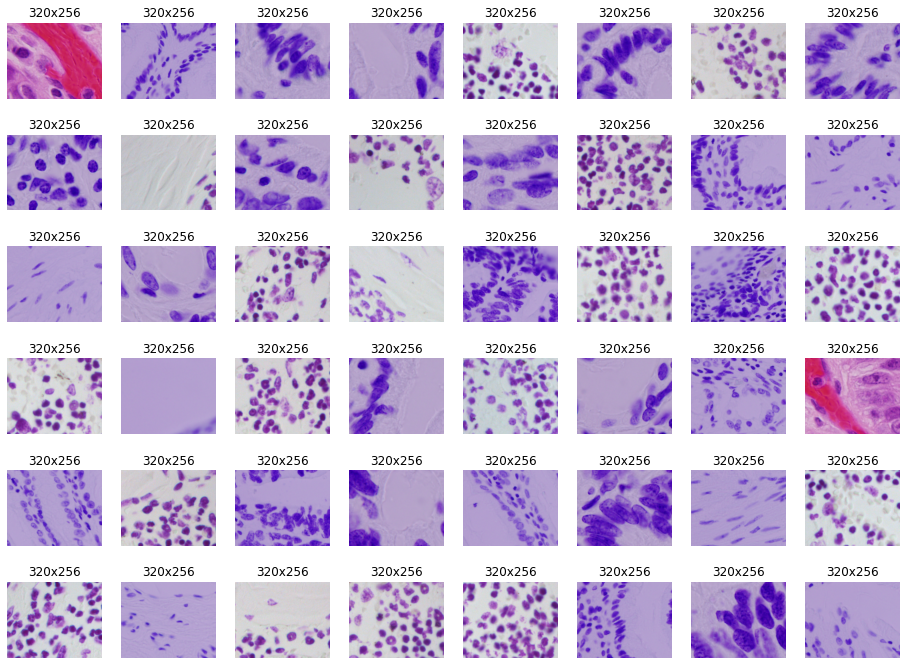

In [ ]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 1][IMAGE_ID].values, 6, 8)

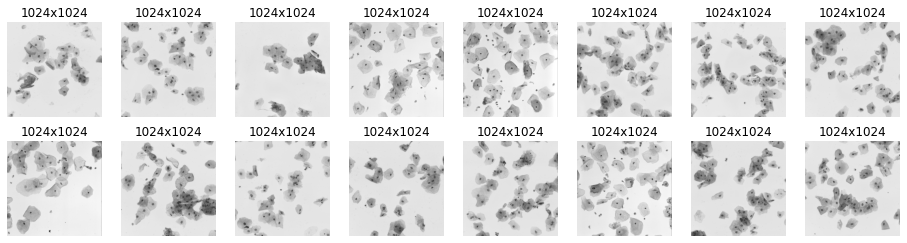

In [ ]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 2][IMAGE_ID].values, 2, 8)

In [ ]:
P = trainPD.groupby(HSV_CLUSTER)[IMAGE_ID].count().reset_index()
P['Percentage'] = 100*P[IMAGE_ID]/P[IMAGE_ID].sum()
print(P)

   hsv_cluster  image_id  Percentage
0            0       546   81.492537
1            1       108   16.119403
2            2        16    2.388060


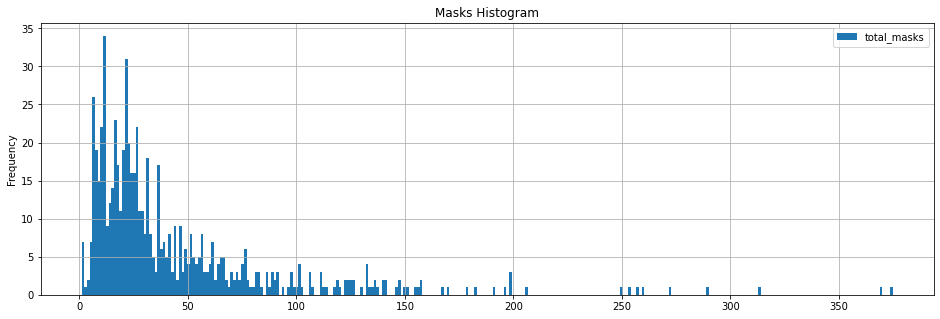

In [ ]:
f, ax = plt.subplots(1,1,figsize=(16,5))
r = trainPD.plot(kind="hist", bins=300, y = TOTAL_MASK, ax=ax, grid=True, title="Masks Histogram")


In [ ]:
def plot_image_masks(image, labels, num_masks, image_id):
    f, ax = plt.subplots(1,3,figsize=(16,5))
    d = ax[0].axis('off')
    d = ax[0].imshow(image)
    d = ax[0].set_title("\n".join(wrap(image_id, 32)))
    d = ax[1].axis('off')
    d = ax[1].imshow(labels)
    d = ax[1].set_title("masks: %d"%num_masks)
    d = ax[2].axis('off')
    d = ax[2].imshow(image)
    d = ax[2].imshow(labels, alpha=0.5)
    d = ax[2].set_title("both")

In [ ]:
def display_image_masks(image_id):
    image, labels, num_masks = read_image_labels(image_id)
    plot_image_masks(image, labels, num_masks, image_id)

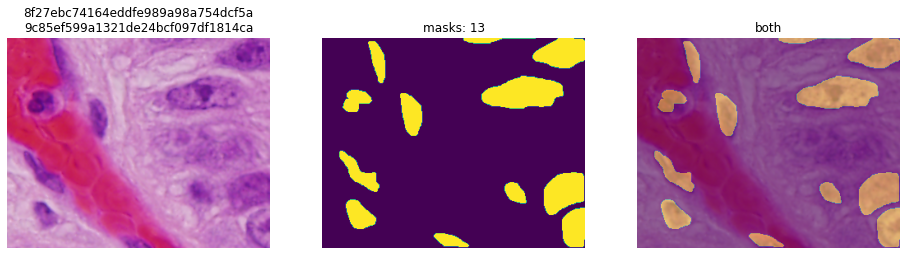

In [ ]:
display_image_masks("8f27ebc74164eddfe989a98a754dcf5a9c85ef599a1321de24bcf097df1814ca")


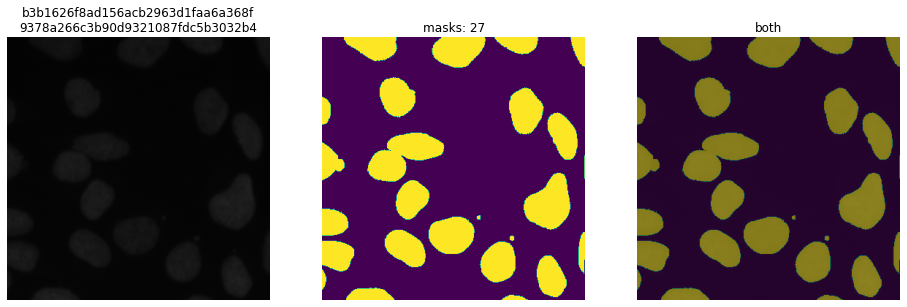

In [ ]:
display_image_masks(trainPD[trainPD[TOTAL_MASK] == trainPD[TOTAL_MASK].median()][IMAGE_ID].values[0])

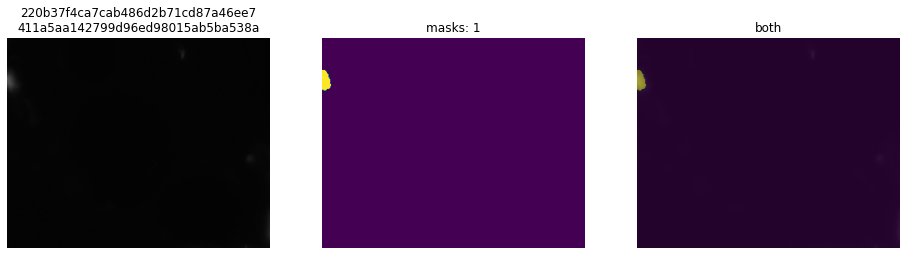

In [ ]:
display_image_masks(trainPD[trainPD[TOTAL_MASK] == trainPD[TOTAL_MASK].min()][IMAGE_ID].values[0])

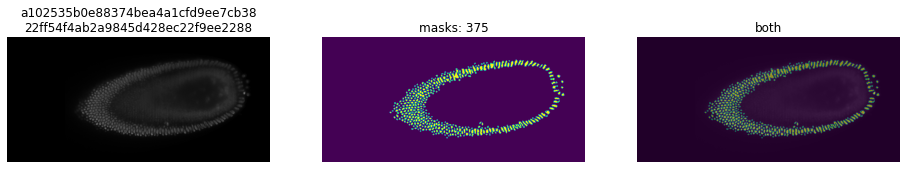

In [ ]:
display_image_masks(trainPD[trainPD[TOTAL_MASK] == trainPD[TOTAL_MASK].max()][IMAGE_ID].values[0])

#Model Development...................

*Otsu's thresholding after Gaussian filtering................*

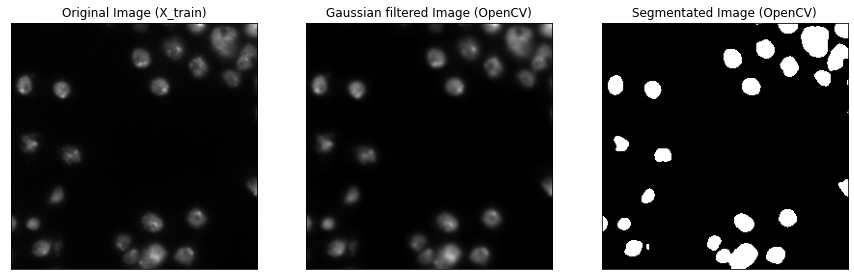

In [ ]:
def openCVdemo():
    ID = '0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9'
    FILE = "/content/gdrive/My Drive/nuclei/stage1_train/{}/images/{}.png".format(ID,ID)
    img = cv2.imread(FILE,0)
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)   
    # Plot Here
    plt.figure(figsize=(15,5))
    images = [blur, 0, th3]
    titles = ['Original Image (X_train)','Gaussian filtered Image (OpenCV)',"Segmentated Image (OpenCV)"]
    plt.subplot(1,3,1),plt.imshow(img,'gray')
    plt.title(titles[0]), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2),plt.imshow(images[0],'gray')
    plt.title(titles[1]), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,3),plt.imshow(images[2],'gray')
    plt.title(titles[2]), plt.xticks([]), plt.yticks([])
openCVdemo()

*Read Data and resize the data..............*

In [ ]:
# Set some parameters
from tqdm import tqdm
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '/content/gdrive/My Drive/nuclei/stage1_train/'
TEST_PATH = '/content/gdrive/My Drive/nuclei/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
print('Done!')

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
print('\nx_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [09:10<00:00,  1.22it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:02<00:00, 26.31it/s]

Done!

x_train (536, 128, 128, 3)
x_test (134, 128, 128, 3)
y_train (536, 128, 128, 1)
y_test (134, 128, 128, 1)


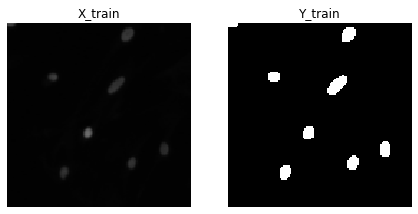

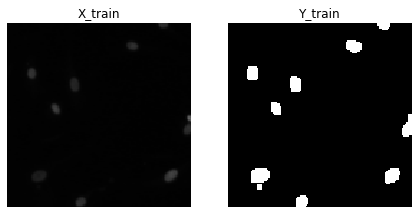

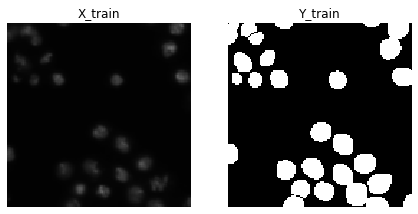

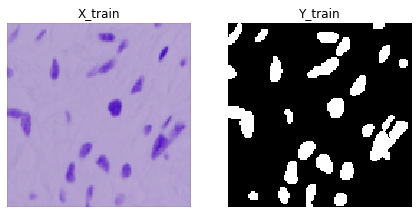

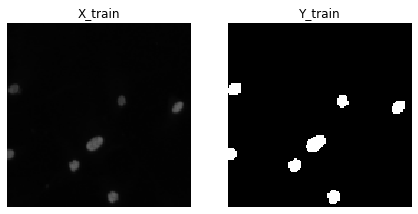

In [ ]:
def plotTrainData(a,b):
    for i in range(5):
        ix = random.randint(0, len(train_ids))
        plt.subplot(1,2,1)
        plt.title("X_train")
        imshow(a[ix])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("Y_train")
        imshow(np.squeeze(b[ix]))
        plt.axis('off')
        plt.show()
plotTrainData(X_train,Y_train)

*Some helper function for Model 1 and 2 Development................*

In [ ]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('/content/gdrive/My Drive/nuclei/logs.npy', allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('/content/gdrive/My Drive/nuclei/accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('/content/gdrive/My Drive/nuclei/loss_curve.png')

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        #y_pred_ = tf.to_int32(y_pred > t)
        y_pred_ = tf.cast(y_pred>t, dtype=tf.int32)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

#RLE encoding for submission
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

*Model 1 - Simple CNN..................*

In [ ]:
y_train = y_train.astype(float)  
y_test = y_test.astype(float) 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, None, None, 8)     224       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, None, None, 8)     584       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, None, None, 16)   

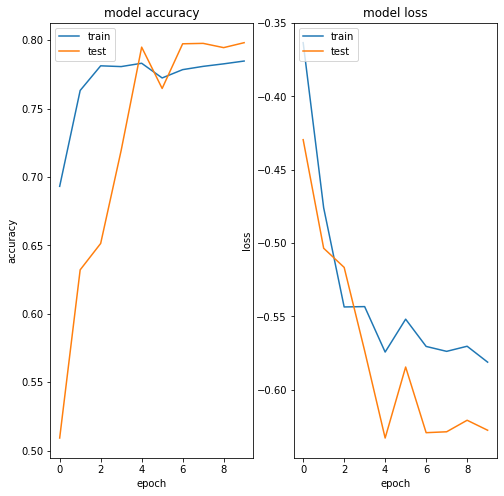

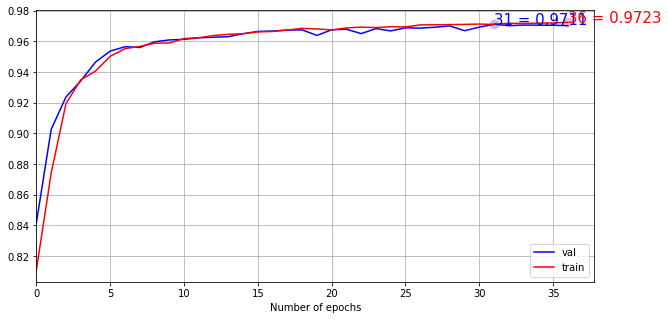

In [ ]:
def SIMPLE(a,b,c,d):
    smooth = 1.
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_coef_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)
    simple_cnn = Sequential()
    simple_cnn.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS),name = 'NormalizeInput'))
    simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
    simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
    # use dilations to get a slightly larger field of view
    simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
    simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
    simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))
    # the final processing
    simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
    simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
    simple_cnn.summary()
    checkpointer = ModelCheckpoint('/content/gdrive/My Drive/nuclei/model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
    earlystopper = EarlyStopping(patience=5, verbose=1)
    simple_cnn.compile(optimizer = 'adam', 
                       loss = dice_coef_loss, 
                       metrics = [dice_coef, 'acc', 'mse'])
    try:
      history = simple_cnn.fit(x_train,y_train, validation_data=(x_test,y_test),callbacks = [earlystopper, checkpointer, MetricsCheckpoint('logs')],epochs = 30)
    except Exception as e:
      print(e)
    plot_learning_curve(history)
    plt.show()
    plotKerasLearningCurve()
    plt.show()
    global modelY
    modelY = simple_cnn
    return modelY
SIMPLE(x_train, y_train,x_test,y_test)

*Prediction using Model 1.................*

5/5 [==============================] - 0s 33ms/step


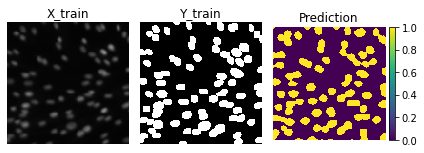

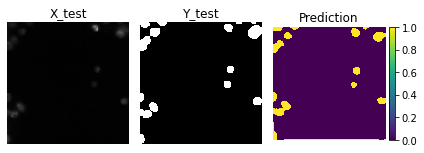

In [ ]:
def plotPredictions(a,b,c,d,e):
    model = e
    # Threshold predictions
    preds_train = model.predict(a[:int(a.shape[0]*0.9)], verbose=1)
    preds_val = model.predict(a[int(a.shape[0]*0.9):], verbose=1)
    preds_test = model.predict(c, verbose=1)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    # Perform a sanity check on some random training samples
    ix = random.randint(0, len(preds_train_t))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    imshow(a[ix])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    imshow(np.squeeze(b[ix]))
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.axis('off')
    imshow(np.squeeze(preds_train_t[ix]))
    plt.show()
    # Perform a sanity check on some random validation samples
    ix = random.randint(0, len(preds_val_t))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    imshow(a[int(a.shape[0]*0.9):][ix])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    imshow(np.squeeze(b[int(b.shape[0]*0.9):][ix]))
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.axis('off')
    imshow(np.squeeze(preds_val_t[ix]))
    plt.show()
plotPredictions(x_train,y_train,x_test,y_test,modelY)

*Model 2 - U-Net.................*

before compile...........
after compile........
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d_28[0][0]                  
_______________________________________

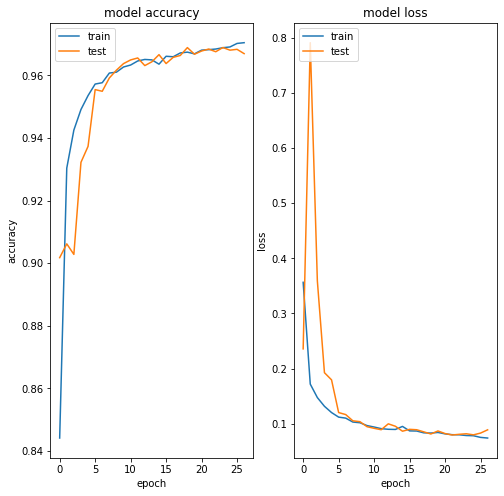

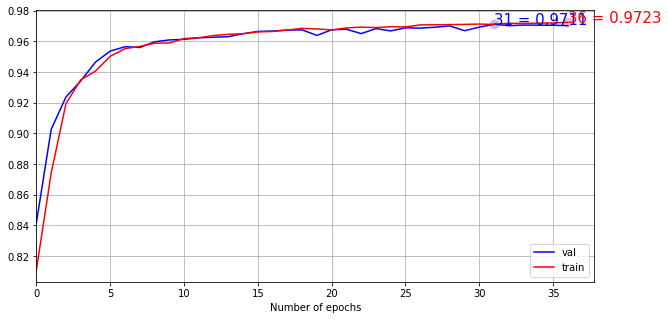

In [ ]:
def UNET(a,b,c,d):
    # Build U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    print("before compile...........")
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou,'accuracy'])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print("after compile........")
    model.summary()
    # Fit model
    earlystopper = EarlyStopping(patience=5, verbose=1)
    try:
      checkpointer = ModelCheckpoint('/content/gdrive/My Drive/nuclei/model-dsbowl2018-2.h5', verbose=1, save_best_only=True)
    except:
      print("exception.................")
    results = model.fit(a,b,batch_size=16,verbose=1,epochs=40,validation_data=(c,d),callbacks = [earlystopper, checkpointer, MetricsCheckpoint('logs')])
    plot_learning_curve(results)
    plt.show()
    plotKerasLearningCurve()
    plt.show()
    global modelZ
    modelZ = model
    return modelZ
UNET(x_train, y_train,x_test,y_test)

*Prediction using Model 2..............*

5/5 [==============================] - 0s 43ms/step


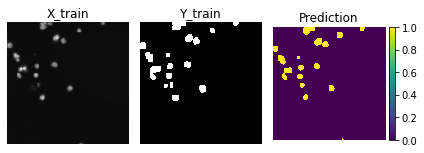

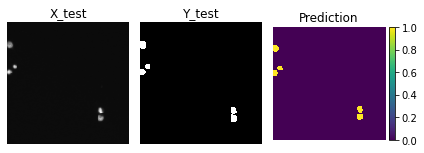

In [ ]:
plotPredictions(x_train,y_train,x_test,y_test,modelZ)


*Submit Results for OpenCV Approach..............*

In [ ]:
TEST_PATH = '/content/gdrive/My Drive/nuclei/stage1_test/'
test_ids = os.listdir(TEST_PATH)
test_image_paths = [glob.glob(join(TEST_PATH, test_id, "images", "*"))[0] for test_id in test_ids]

def threshold(image_gray):
    image_gray = cv2.GaussianBlur(image_gray, (7, 7), 1)
    ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    max_cnt_area = cv2.contourArea(cnts[0])
    
    if max_cnt_area > 50000:
        ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    return thresh

def apply_morphology(thresh):
    mask = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    return mask

segmented = []
for test_image_path in tqdm(test_image_paths):
    tmp_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    thresh = threshold(tmp_image)
    mask = apply_morphology(thresh)
    segmented.append(mask)

# Submit Results for OpenCV Approach
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(segmented[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

submission_df = pd.DataFrame()
submission_df['ImageId'] = new_test_ids
submission_df['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
#submission_df.sample(3)
#submission_df.to_csv('modelX.csv', index=False)
#print("\nMethod 1: OpenCV")
#print("Results Saved")

# Submit Results for Deep Learning Approaches
def saveResults(a,b):        
    preds_test = a.predict(b, verbose=1)
    # Create list of upsampled test masks
    preds_test_upsampled = []
    for i in range(len(preds_test)):
        preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                           (sizes_test[i][0], sizes_test[i][1]), 
                                           mode='constant', preserve_range=True))
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(test_ids):
        rle = list(prob_to_rles(preds_test_upsampled[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    # Create submission DataFrame
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    sub.to_csv('/content/gdrive/My Drive/nuclei'+a.name+'.csv', index=False)
    print("Results Saved")
print("\nMethod 2: Simple CNN")
saveResults(modelY,X_test)
print("\nMethod 3: U-Net CNN")
saveResults(modelZ,X_test)

100%|██████████| 65/65 [00:00<00:00, 83.00it/s]



Method 2: Simple CNN
3/3 [==============================] - 0s 79ms/step
Results Saved

Method 3: U-Net CNN
3/3 [==============================] - 0s 153ms/step
Results Saved


In [ ]:
"""
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '/content/gdrive/My Drive/nuclei/stage1_train/'
TEST_PATH = '/content/gdrive/My Drive/nuclei/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
"""

In [ ]:
"""
from tqdm import tqdm
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')
"""

In [ ]:
#https://www.kaggle.com/raoulma/nuclei-dsb-2018-tensorflow-u-net-score-0-352?scriptVersionId=2554959
#https://www.kaggle.com/jerrythomas/exploratory-analysis
#https://www.kaggle.com/mpware/stage1-eda-microscope-image-types-clustering
#https://www.kaggle.com/paultimothymooney/identification-and-segmentation-of-nuclei-in-cells/notebook?select=logs.npy
#https://www.kaggle.com/paultimothymooney/identification-and-segmentation-of-nuclei-in-cells
#https://www.kaggle.com/kmader/keras-linknet